In this post, I am going to show how the signs can change as we add more features to a logistic regression equation.  I am also going to explain why the signs flip.  

To start I am loading in the `Default` dataset. 

In [1]:
import pandas as pd 

df = pd.read_csv('https://raw.githubusercontent.com/sik-flow/datasets/master/Default.csv')
df.head()

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


I am first going to build a model using student (a categorical feature) to predict whether someone defaults on a loan or not.  

In [2]:
import statsmodels.api as sm

X = df[['student']]
y = df['default']

X = sm.add_constant(X)

logit = sm.Logit(y, X).fit()
logit.summary()

/Users/jeffreyherman/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9998
Method:                           MLE   Df Model:                            1
Date:                Sat, 01 Aug 2020   Pseudo R-squ.:                0.004097
Time:                        21:12:23   Log-Likelihood:                -1454.3
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                 0.0005416
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5041      0.071    -49.554      0.000      -3.643      -3.366
student        0.4049      0.115      3.520      0.000       0.179       0.630
==============================================================================
"""

I see that the coefficient for student is positive which means that a student has a probability of defaulting than a non-student I can check this with the following. 

In [3]:
import numpy as np

# probabiliy of student 
np.exp(-3.5041 + 0.4049) / (1 + np.exp(-3.5041 + 0.4049))

0.04314026622102699

In [4]:
# probabiliy of non-student 
np.exp(-3.5041) / (1 + np.exp(-3.5041))

0.029195798210381152

We see the probability of a student to default is 4.3% and a non-student is 2.9% from our logistic regression model.  This should line up with what our original data is.  We can check this with the following: 

In [5]:
# student 
df[df['student'] == 1]['default'].value_counts(normalize = True)

0    0.956861
1    0.043139
Name: default, dtype: float64

In [6]:
# non-student 
df[df['student'] == 0]['default'].value_counts(normalize = True)

0    0.970805
1    0.029195
Name: default, dtype: float64

We see that it does line up with our logistic regression model.  Now lets see what happens when I add an additional feature `balance` to the model. 

In [7]:
X = df[['student', 'balance']]
y = df['default']

X = sm.add_constant(X)

logit = sm.Logit(y, X).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.078584
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Sat, 01 Aug 2020   Pseudo R-squ.:                  0.4619
Time:                        21:12:23   Log-Likelihood:                -785.84
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                1.189e-293
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.7495      0.369    -29.115      0.000     -11.473     -10.026
student       -0.7149      0.148     -4.846      0.000      -1.004      -0.426
balance        0.0057      0.000     24.748      0.000       0.005       0.006
==============================================================================

Possibly complete quasi-separation: A fraction 0.15 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

We now see that student has a negative coefficient, which means that students when balance is held constant students default at a lower rate than non-students.  This contradicts what our single variable logistic regression models says.  Lets take a look at why this happens. 

I am first going to build a model that shows the rate at which students and non-students default at different balances. 

In [8]:
import seaborn as sns 
import matplotlib.pyplot as plt

In [9]:
my_vals = [0] + [i for i in range(500, 2500, 100)] + [3000]
student = []
non_student = []
for counter, x in enumerate(my_vals):
    if counter + 1 < len(my_vals):
        stud_val = df[(df['student']==1) & (df['balance'] > x) & (df['balance'] < my_vals[counter+1])]['default']
        student.append((stud_val == 1).sum() / len(stud_val))
        nstud_val = df[(df['student']==0) & (df['balance'] > x) & (df['balance'] < my_vals[counter+1])]['default']
        non_student.append((nstud_val == 1).sum() / len(nstud_val))

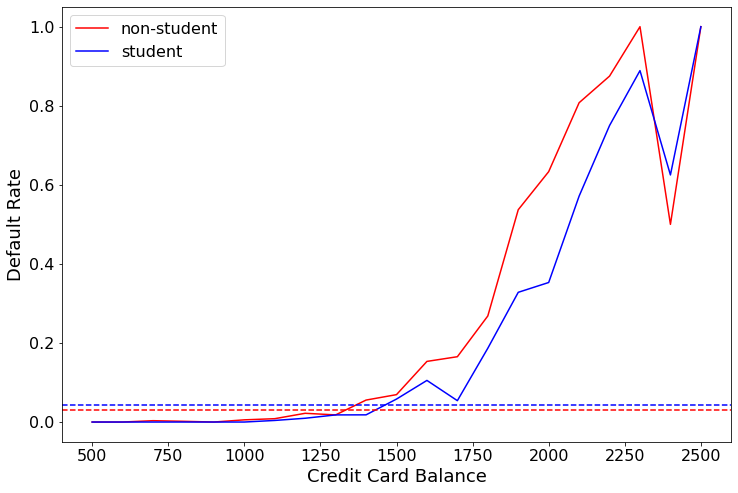

In [10]:
plt.figure(figsize = (12, 8))
plt.plot(range(500, 2600, 100), non_student, color = 'red', label = 'non-student')
plt.plot(range(500, 2600, 100), student, color = 'blue', label = 'student')
plt.axhline(df[df['student'] == 0]['default'].value_counts(normalize = True)[1], 
           color = 'red', ls = '--')
plt.axhline(df[df['student'] == 1]['default'].value_counts(normalize = True)[1], 
           color = 'blue', ls = '--')
plt.legend(fontsize = 16)
plt.xlabel('Credit Card Balance', fontsize = 18)
plt.ylabel('Default Rate', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16);

The horizontal lines are the overall default rate for students (blue) and non-students.  We see that the blue dotted line is above the red dotted line, this is why when looking at the single variable logistic regression it showed that students were more likely to default than non-students.  The line plot shows that at the same credit card balance, students are more likely to not default than non-students. 

Additionally, I want to look at the balance distribution for students and non-students. 

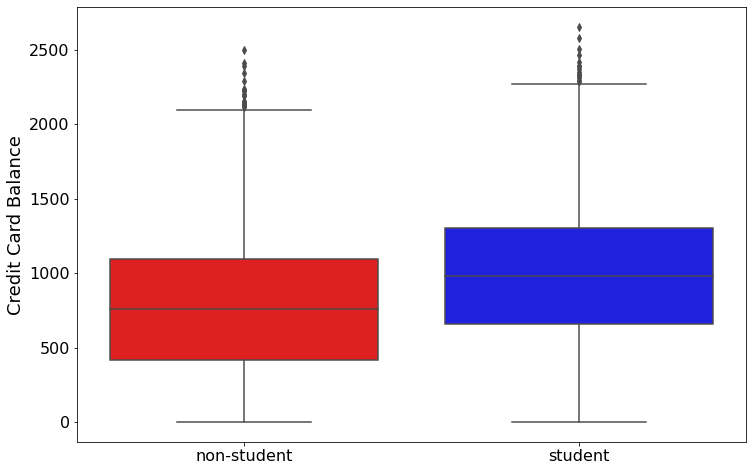

In [11]:
plt.figure(figsize = (12, 8))
sns.boxplot(x = 'student', y = 'balance', data = df, palette =  ['r', 'b'])
plt.xticks(range(2), ['non-student', 'student'], fontsize = 16)
plt.xlabel('')
plt.ylabel('Credit Card Balance', fontsize = 18)
plt.yticks(fontsize = 16);

We see that students on average have a higher balance than non-students.  But, we see when a student and a non-student have the same balance - the student is less likely to default. 

Lets look at the probability of default for a student and non-student when they both have a $2000 balance. 

In [12]:
# student
np.exp(-10.75 + 0.0057 * 2000 - 0.7149) / (1 + np.exp(-10.75 + 0.0057 * 2000 - 0.7149))

0.483780692590808

In [13]:
# non-student
np.exp(-10.75 + 0.0057 * 2000) / (1 + np.exp(-10.75 + 0.0057 * 2000))

0.6570104626734988

A student has a probability of defaulting at 48% and a non-student has a probability of defaulting of 66%.  

#### References
- [An Introduction to Statistical Learning with Applications in R](http://faculty.marshall.usc.edu/gareth-james/ISL/)